In [1]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import OneHotEncoder  
from sklearn.preprocessing import OrdinalEncoder

import pickle

plt.rcParams["figure.figsize"] = (10,8)

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append("../")

import src.support as sp

### `Exploración y preprocesado`

In [2]:
df = pd.read_csv("../data/train.csv")

In [3]:
df.head()

,id,carat,cut,color,clarity,depth,table,x,y,z,price
0,0,0.30,Premium,D,SI2,62.4,58.0,4.31,4.28,2.68,6.353
1,1,1.01,Ideal,E,VVS2,62.7,56.0,6.42,6.46,4.04,9.183
2,2,0.72,Ideal,F,VS2,61.8,59.0,5.71,5.74,3.54,7.983
3,3,1.08,Very Good,G,SI2,63.2,57.0,6.54,6.50,4.12,8.371
4,4,0.36,Premium,G,VS1,62.3,59.0,4.50,4.55,2.82,6.588


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       40455 non-null  int64  
 1   carat    40455 non-null  float64
 2   cut      40455 non-null  object 
 3   color    40455 non-null  object 
 4   clarity  40455 non-null  object 
 5   depth    40455 non-null  float64
 6   table    40455 non-null  float64
 7   x        40455 non-null  float64
 8   y        40455 non-null  float64
 9   z        40455 non-null  float64
 10  price    40455 non-null  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 3.4+ MB


In [5]:
df.shape

(40455, 11)

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,40455.0,20227.000000,11678.496907,0.000,10113.500,20227.00,30340.500,40454.000
carat,40455.0,0.797576,0.475939,0.200,0.400,0.70,1.040,5.010
depth,40455.0,61.746377,1.436796,43.000,61.000,61.80,62.500,79.000
table,40455.0,57.451694,2.234569,44.000,56.000,57.00,59.000,95.000
x,40455.0,5.729163,1.125244,0.000,4.710,5.69,6.540,10.740
y,40455.0,5.732896,1.154799,0.000,4.720,5.70,6.540,58.900
z,40455.0,3.537351,0.711002,0.000,2.910,3.52,4.030,31.800
price,40455.0,7.783822,1.016828,5.787,6.851,7.78,8.581,9.842


In [7]:
df.isnull().sum()

id         0
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
x          0
y          0
z          0
price      0
dtype: int64

#### `Variable respuesta`

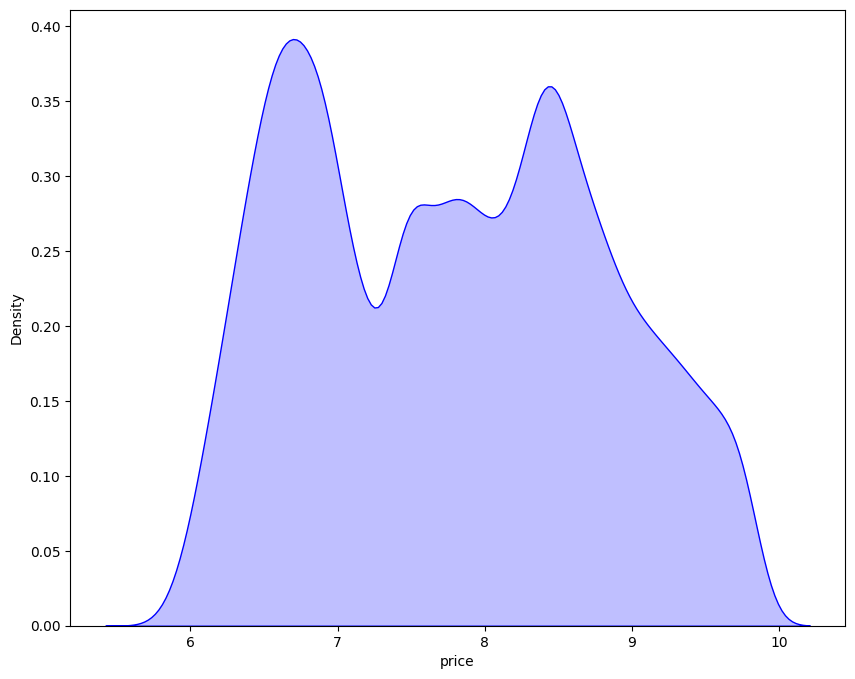

In [8]:
sns.distplot(
    df.price,
    hist = False,
    color = "blue",
    kde_kws = {"shade": True, "linewidth": 1});


#### `Variables predictoras`

In [9]:
df["x"].replace(0, df["x"].mean(), inplace=True)
df["y"].replace(0, df["y"].mean(), inplace=True)
df["z"].replace(0, df["z"].mean(), inplace=True)

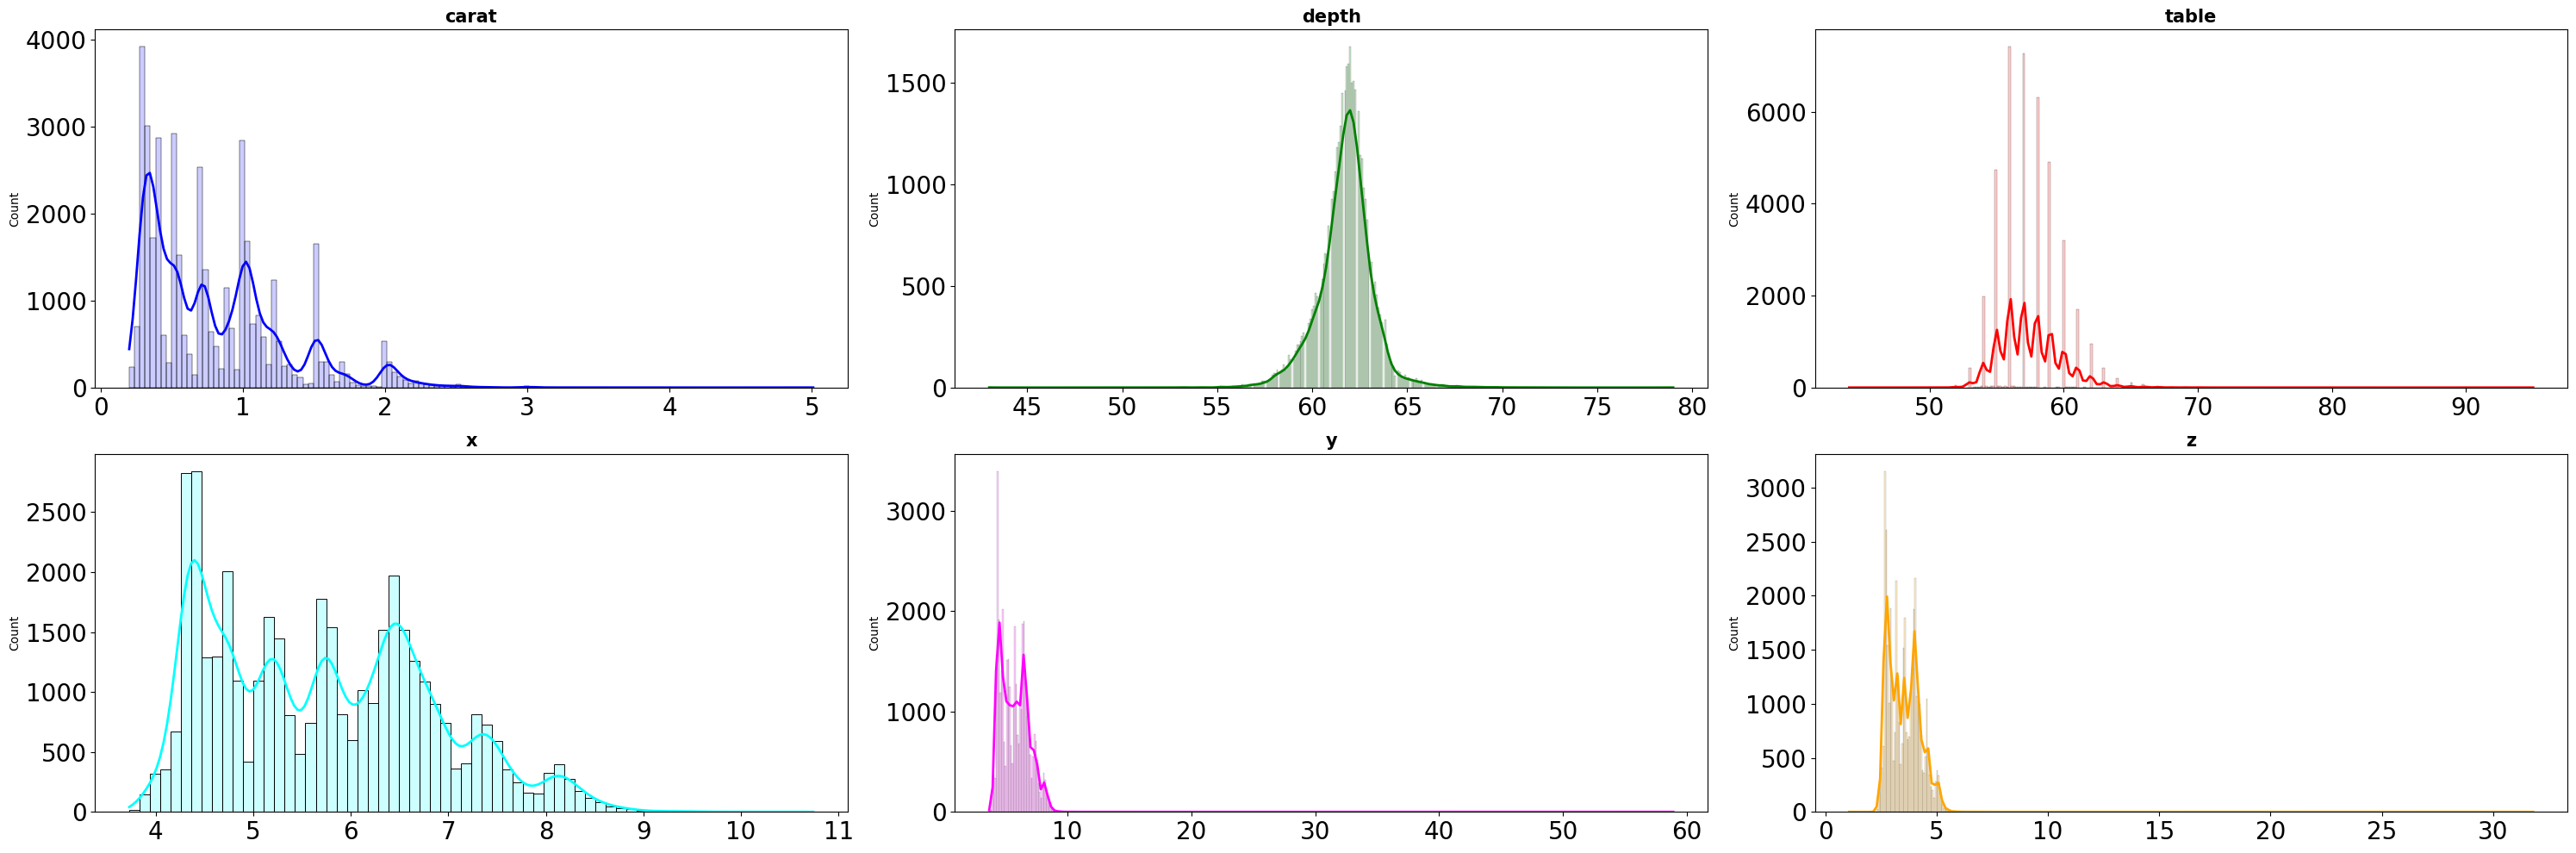

In [10]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (30, 10))

lista_colores = ["blue", "green", "red", "cyan", "magenta", "orange"]

axes = axes.flat

columnas_numeric = df.select_dtypes(include = np.number).columns
columnas_numeric = columnas_numeric.drop(["price", "id"])

for i, colum in enumerate(columnas_numeric):
    sns.histplot(
        data = df,
        x = colum,
        kde = True,
        color = lista_colores[i],
        line_kws = {"linewidth": 2},
        alpha = 0.2,
        ax = axes[i])
    
    
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
    

fig.tight_layout();

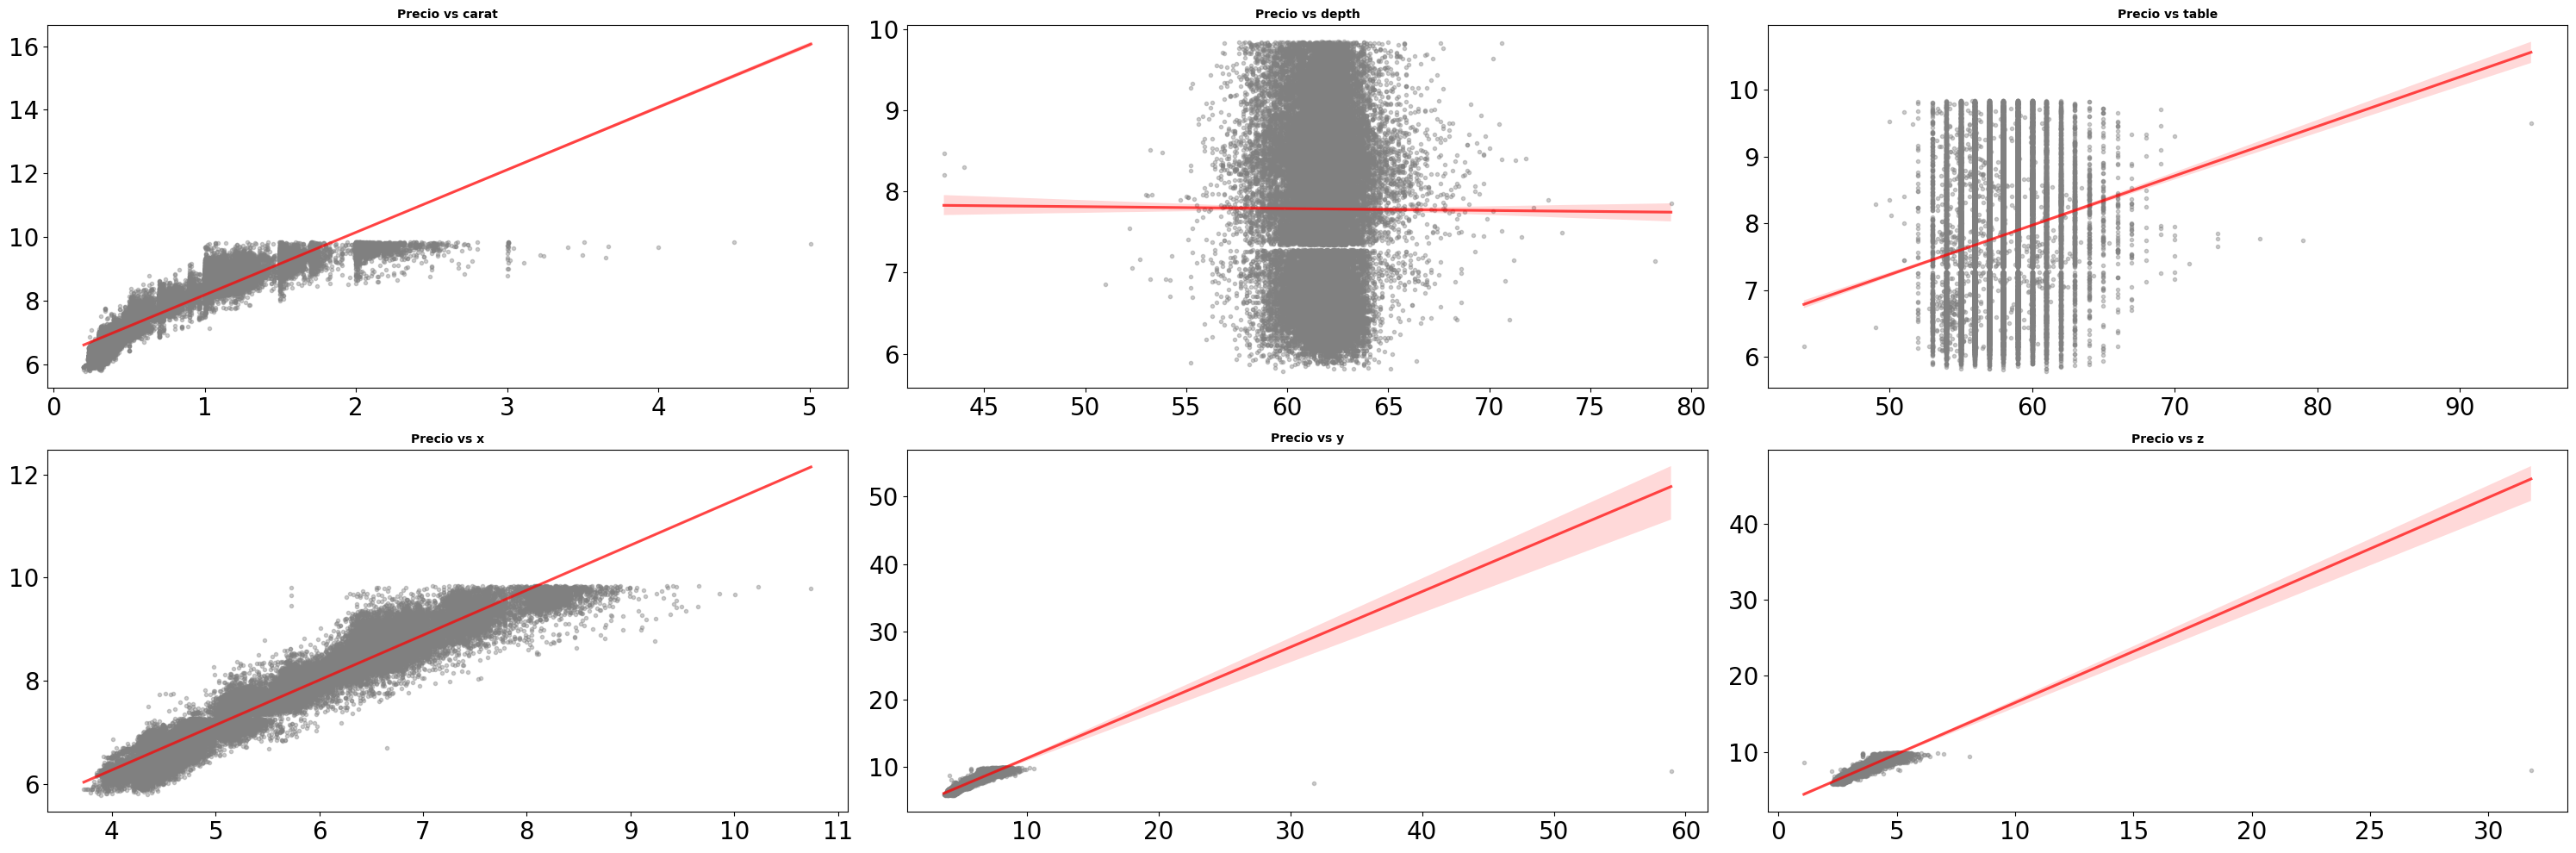

In [11]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (30, 10))

lista_colores = ["blue", "green", "red", "cyan", "magenta", "orange"]

axes = axes.flat

columnas_numeric = df.select_dtypes(include = np.number).columns
columnas_numeric = columnas_numeric.drop(["price", "id"])

for i, colum in enumerate(columnas_numeric):
    sns.regplot(
        x = df[colum], 
        y = df["price"], 
        color = "gray", 
        marker = ".", 
        scatter_kws = {"alpha": 0.4}, 
        line_kws = {"color": "red", "alpha": 0.7 }, 
        ax = axes[i])
    
    axes[i].set_title(f"Precio vs {colum}", fontsize = 10, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    
fig.tight_layout();

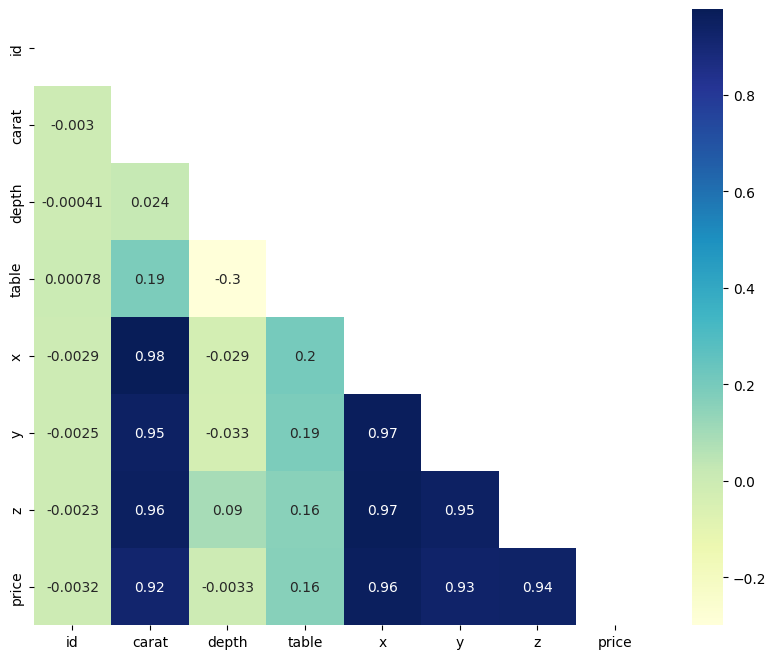

In [12]:
mask = np.triu(np.ones_like(df.corr(), dtype = np.bool))
sns.heatmap(df.corr(), 
           cmap = "YlGnBu", 
            mask = mask,
           annot = True);

#### `Variables categóricas`

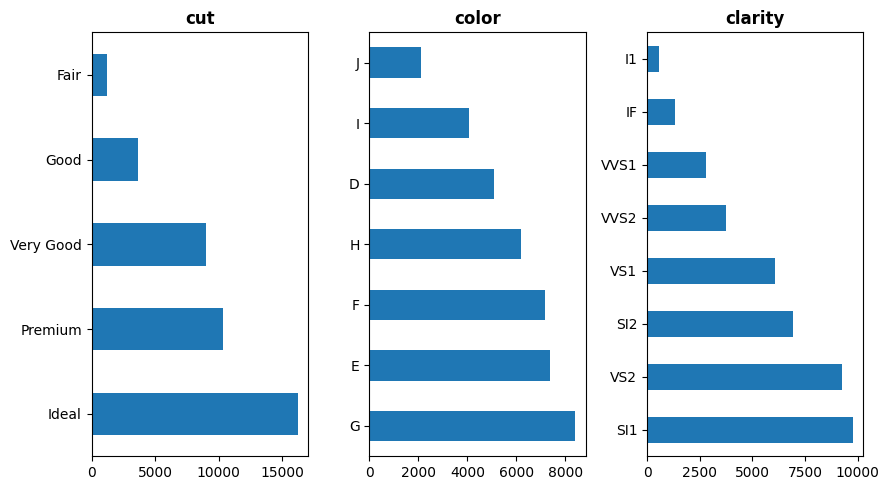

In [13]:
fig, axes = plt.subplots(1, 3, figsize = (9,5))

axes = axes.flat

columnas_object = df.select_dtypes(include = "object").columns

for i, colum in enumerate(columnas_object):
    df[colum].value_counts().plot.barh(ax = axes[i])
    axes[i].set_title(colum, fontsize = 12, fontweight = "bold")
    axes[i].tick_params(labelsize = 10)
    axes[i].set_xlabel("")

fig.tight_layout();


### `Gestión de outliers`

In [14]:
df_numericas = df.select_dtypes(include=np.number)

Como "table" tiene una correlación muy baja y "depth" también (además de que depende de las variables
x, y y z), nos las podemos cargar.

In [15]:
df_numericas.drop(["id", "table", "depth"], axis=1, inplace=True)

In [16]:
df_numericas.columns

Index(['carat', 'x', 'y', 'z', 'price'], dtype='object')

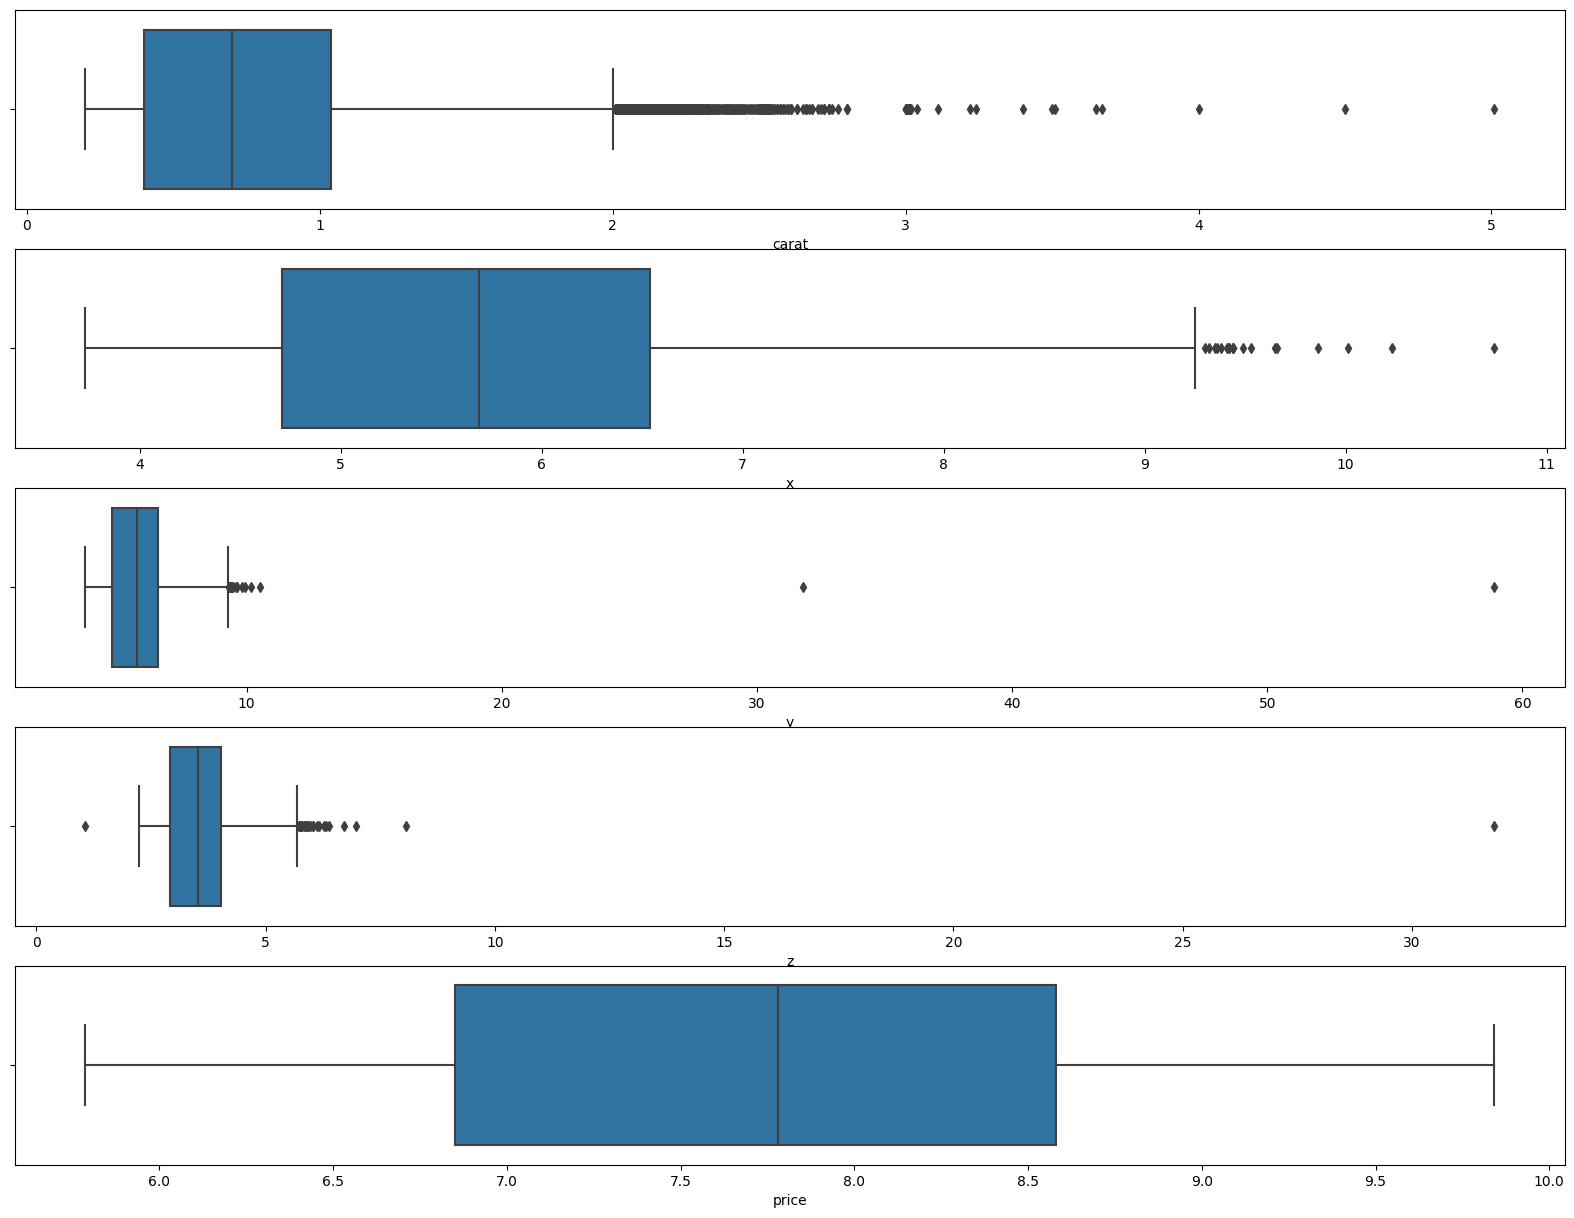

In [17]:
fig, ax = plt.subplots(5, 1, figsize=(20,15))

for i in range(len(df_numericas.columns)):
    sns.boxplot(x=df_numericas.columns[i], data=df_numericas, ax=ax[i])
plt.show()

In [18]:
ind = sp.detectar_outliers(df_numericas.columns, df_numericas)

In [19]:
for k, v in ind.items():
        mediana = df[k].median()
        for i in v:
            df.loc[i,k] = mediana

In [20]:
df_numericas2 = df.select_dtypes(include = np.number)

In [21]:
df_numericas2.drop(["id", "table", "depth"], axis=1, inplace=True)

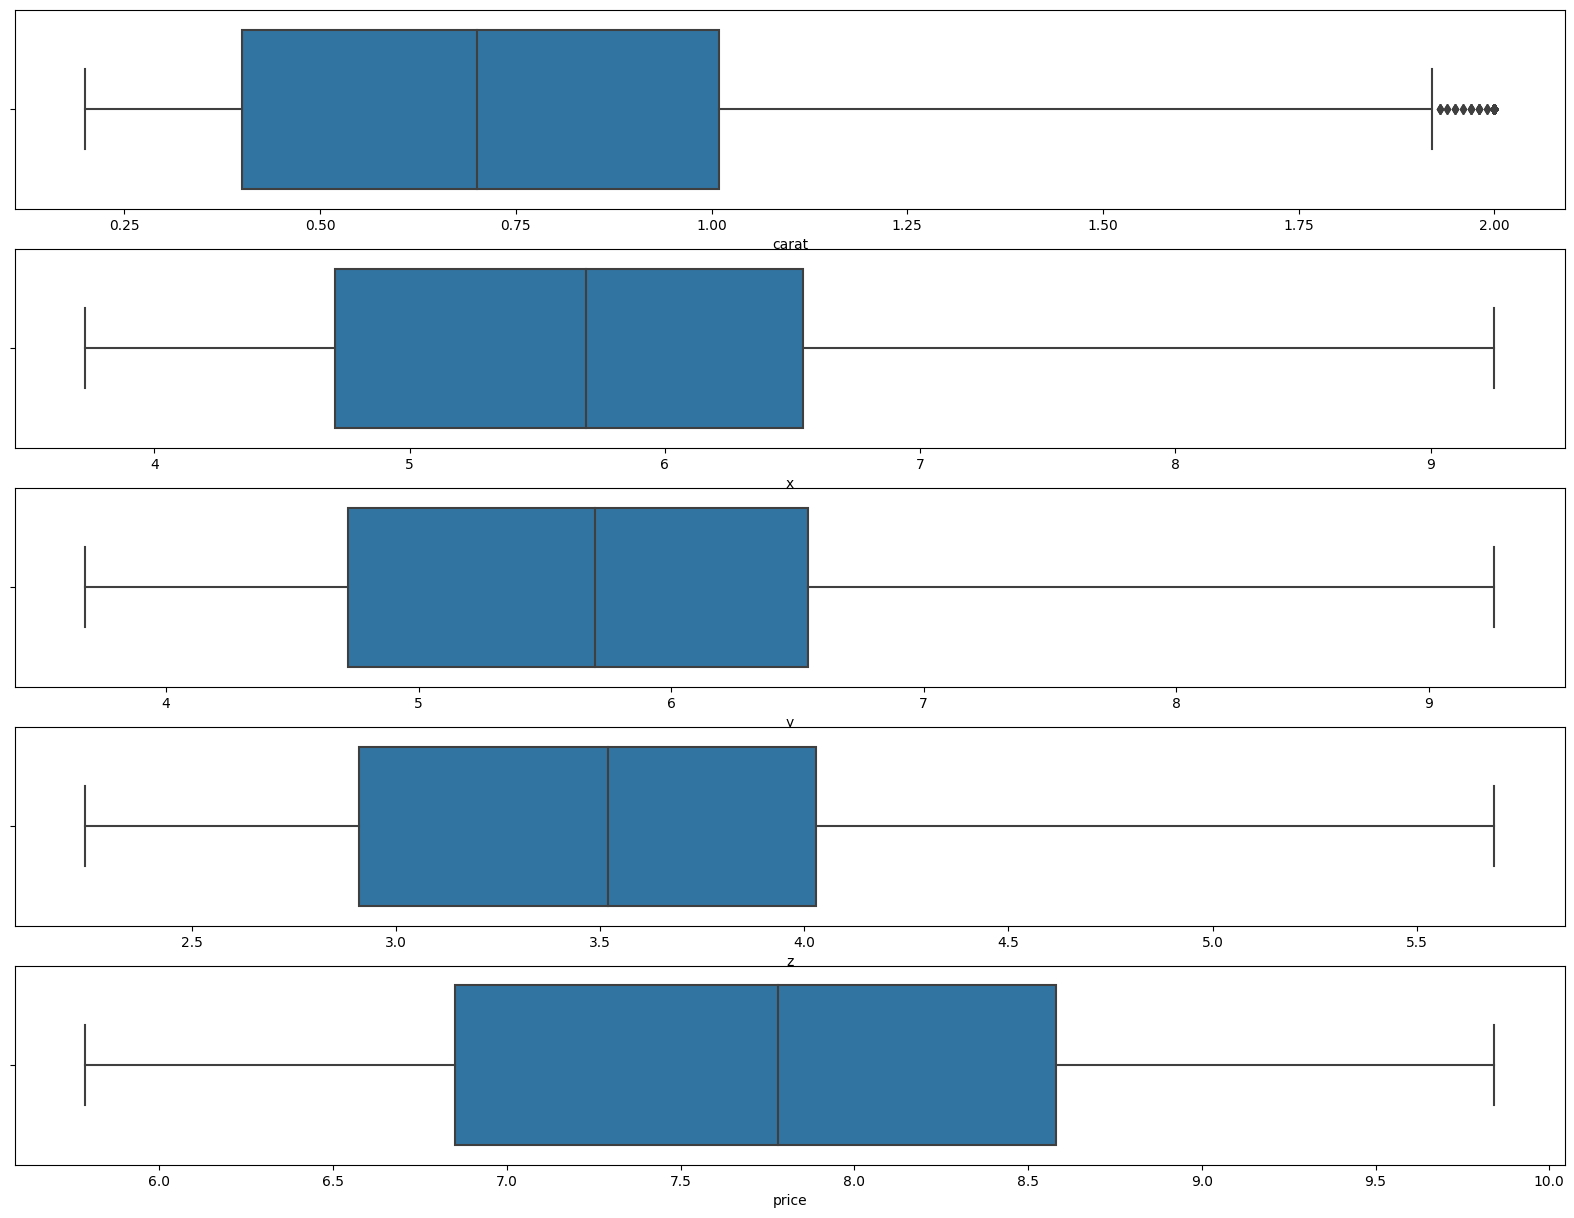

In [22]:
fig, ax = plt.subplots(5, 1, figsize=(20,15))

for i in range(len(df_numericas2.columns)):
    sns.boxplot(x=df_numericas2.columns[i], data=df_numericas2, ax=ax[i])
plt.show()

In [23]:
df.to_csv("../data/train_outliers_deleted.csv")

### `Normalización`

In [24]:
media = df["price"].mean()
maximo = df["price"].max() 
minimo = df["price"].min()

In [25]:
df["price_NORM"] = (df["price"] - media) / (maximo - minimo )

In [26]:
df.head(2)

,id,carat,cut,color,clarity,depth,table,x,y,z,price,price_NORM
0,0,0.30,Premium,D,SI2,62.4,58.0,4.31,4.28,2.68,6.353,-0.352854
1,1,1.01,Ideal,E,VVS2,62.7,56.0,6.42,6.46,4.04,9.183,0.345050


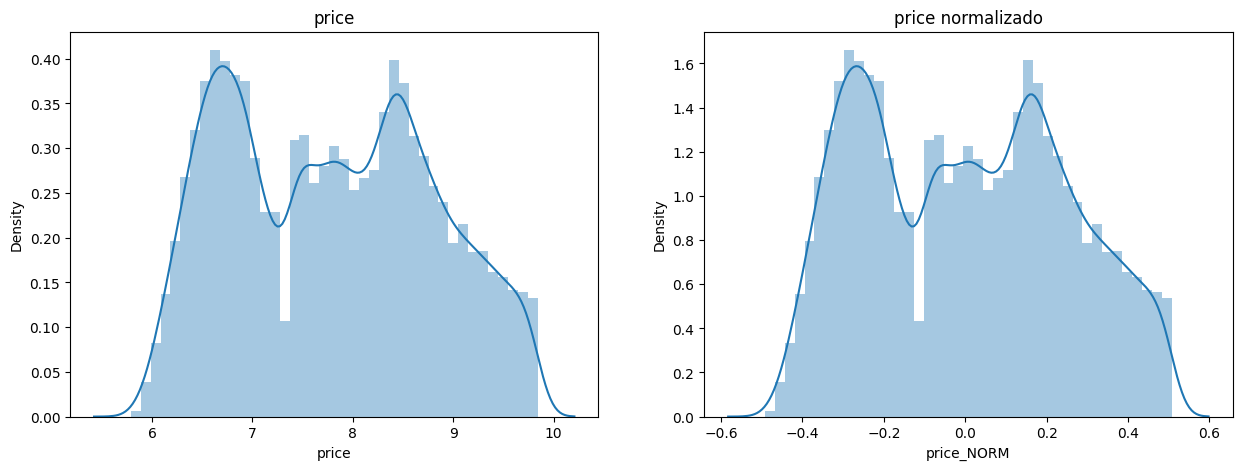

In [27]:
fig, axes = plt.subplots(1, 2, figsize = (15,5))

axes[0].set_title('price')
axes[1].set_title('price normalizado')

sns.distplot(df['price'] ,ax = axes[0])
sns.distplot(df['price_NORM'], ax = axes[1]);

In [28]:
df['price_LOG'] = df['price'].apply(lambda x: np.log(x) if x != 0 else 0)

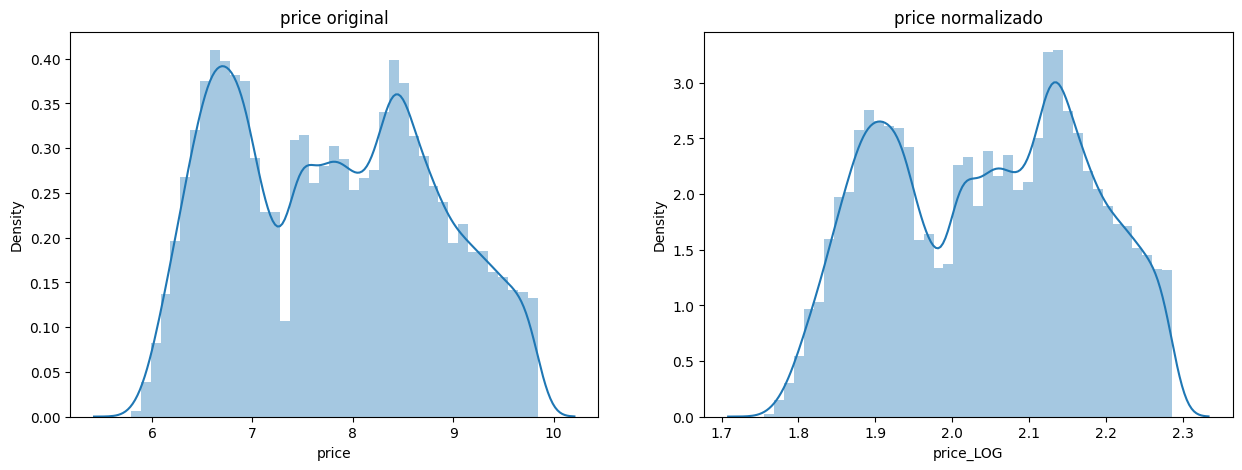

In [29]:
fig, axes = plt.subplots(1, 2, figsize = (15,5))

axes[0].set_title('price original')
axes[1].set_title('price normalizado')

sns.distplot(df['price'] ,ax = axes[0])
sns.distplot(df['price_LOG'], ax = axes[1]);

In [30]:
df['price_SQRT'] = df['price'].apply(lambda x: math.sqrt(x))

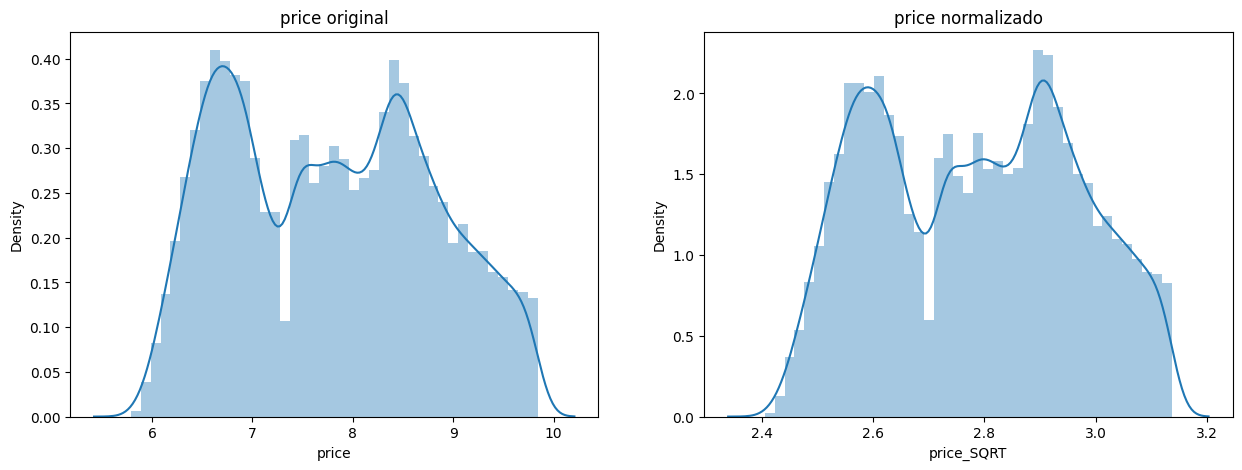

In [31]:
fig, axes = plt.subplots(1, 2, figsize = (15,5))

axes[0].set_title('price original')
axes[1].set_title('price normalizado')

sns.distplot(df['price'] ,ax = axes[0])
sns.distplot(df['price_SQRT'], ax = axes[1]);

In [32]:
minmax = MinMaxScaler()

In [33]:
minmax.fit(df[["price"]])

MinMaxScaler()

In [34]:
X_normalizadas = minmax.transform(df[["price"]])

In [35]:
X_normalizadas.min(axis=0)

array([0.])

In [36]:
X_normalizadas.max(axis=0)

array([1.])

In [37]:
df["price_NORM2"] = X_normalizadas

In [38]:
df.head(2)


,id,carat,cut,color,clarity,depth,table,x,y,z,price,price_NORM,price_LOG,price_SQRT,price_NORM2
0,0,0.30,Premium,D,SI2,62.4,58.0,4.31,4.28,2.68,6.353,-0.352854,1.848927,2.520516,0.139581
1,1,1.01,Ideal,E,VVS2,62.7,56.0,6.42,6.46,4.04,9.183,0.345050,2.217354,3.030347,0.837485


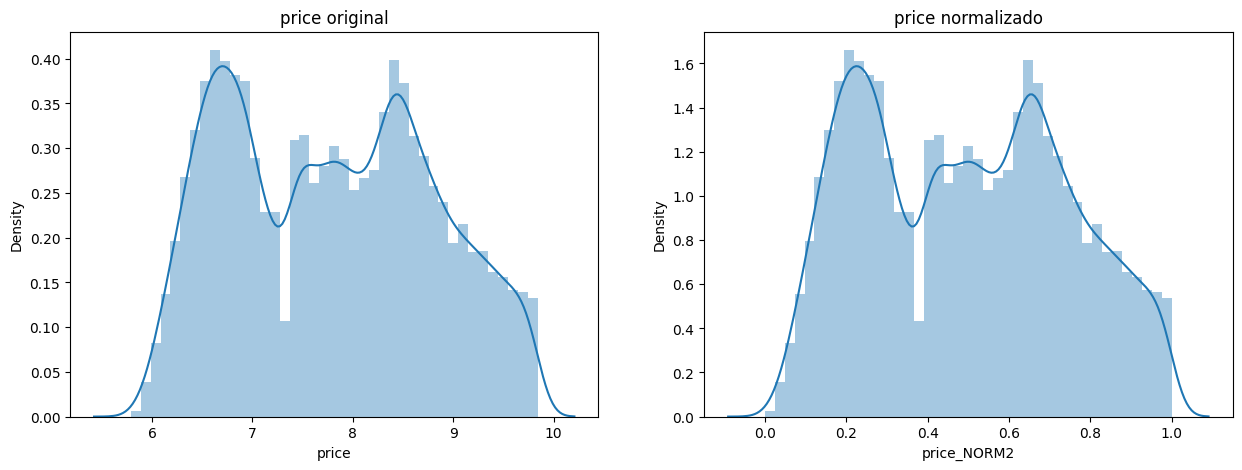

In [39]:
fig, axes = plt.subplots(1, 2, figsize = (15,5))

axes[0].set_title('price original')
axes[1].set_title('price normalizado')

sns.distplot(df['price'] ,ax = axes[0])
sns.distplot(df['price_NORM2'], ax = axes[1]);

### `Estandarización`

In [40]:
df.head()

,id,carat,cut,color,clarity,depth,table,x,y,z,price,price_NORM,price_LOG,price_SQRT,price_NORM2
0,0,0.30,Premium,D,SI2,62.4,58.0,4.31,4.28,2.68,6.353,-0.352854,1.848927,2.520516,0.139581
1,1,1.01,Ideal,E,VVS2,62.7,56.0,6.42,6.46,4.04,9.183,0.345050,2.217354,3.030347,0.837485
2,2,0.72,Ideal,F,VS2,61.8,59.0,5.71,5.74,3.54,7.983,0.049119,2.077314,2.825420,0.541554
3,3,1.08,Very Good,G,SI2,63.2,57.0,6.54,6.50,4.12,8.371,0.144803,2.124773,2.893268,0.637238
4,4,0.36,Premium,G,VS1,62.3,59.0,4.50,4.55,2.82,6.588,-0.294901,1.885250,2.566710,0.197534


In [41]:
scaler = StandardScaler()

In [42]:
num_col = df_numericas2.columns.drop("price")
num_col

Index(['carat', 'x', 'y', 'z'], dtype='object')

In [43]:
scaler.fit(df[num_col])

StandardScaler()

In [44]:
X_escaladas = scaler.transform(df[num_col])
X_escaladas

array([[-1.12754228, -1.26688195, -1.30434556, -1.24141746],
       [ 0.66975805,  0.61783135,  0.65621072,  0.72954527],
       [-0.06435054, -0.01636127,  0.00868754,  0.00492662],
       ...,
       [ 0.13816218,  0.11762308,  0.15258158,  0.22231222],
       [ 0.66975805,  0.59996677,  0.67419747,  0.61360629],
       [ 1.40386664,  1.22522711,  1.26776038,  1.07736223]])

In [45]:
df2 = df.copy()

In [46]:
df2[num_col] = X_escaladas
df2.head()

,id,carat,cut,color,clarity,depth,table,x,y,z,price,price_NORM,price_LOG,price_SQRT,price_NORM2
0,0,-1.127542,Premium,D,SI2,62.4,58.0,-1.266882,-1.304346,-1.241417,6.353,-0.352854,1.848927,2.520516,0.139581
1,1,0.669758,Ideal,E,VVS2,62.7,56.0,0.617831,0.656211,0.729545,9.183,0.345050,2.217354,3.030347,0.837485
2,2,-0.064351,Ideal,F,VS2,61.8,59.0,-0.016361,0.008688,0.004927,7.983,0.049119,2.077314,2.825420,0.541554
3,3,0.846957,Very Good,G,SI2,63.2,57.0,0.725019,0.692184,0.845484,8.371,0.144803,2.124773,2.893268,0.637238
4,4,-0.975658,Premium,G,VS1,62.3,59.0,-1.097168,-1.061524,-1.038524,6.588,-0.294901,1.885250,2.566710,0.197534


In [47]:
df2.drop(["table","depth"], axis=1, inplace=True)

In [48]:
df2.head()

,id,carat,cut,color,clarity,x,y,z,price,price_NORM,price_LOG,price_SQRT,price_NORM2
0,0,-1.127542,Premium,D,SI2,-1.266882,-1.304346,-1.241417,6.353,-0.352854,1.848927,2.520516,0.139581
1,1,0.669758,Ideal,E,VVS2,0.617831,0.656211,0.729545,9.183,0.345050,2.217354,3.030347,0.837485
2,2,-0.064351,Ideal,F,VS2,-0.016361,0.008688,0.004927,7.983,0.049119,2.077314,2.825420,0.541554
3,3,0.846957,Very Good,G,SI2,0.725019,0.692184,0.845484,8.371,0.144803,2.124773,2.893268,0.637238
4,4,-0.975658,Premium,G,VS1,-1.097168,-1.061524,-1.038524,6.588,-0.294901,1.885250,2.566710,0.197534


In [49]:
with open('../data/estandarizacion.pkl', 'wb') as s:
    pickle.dump(scaler, s)

### `Encoding`

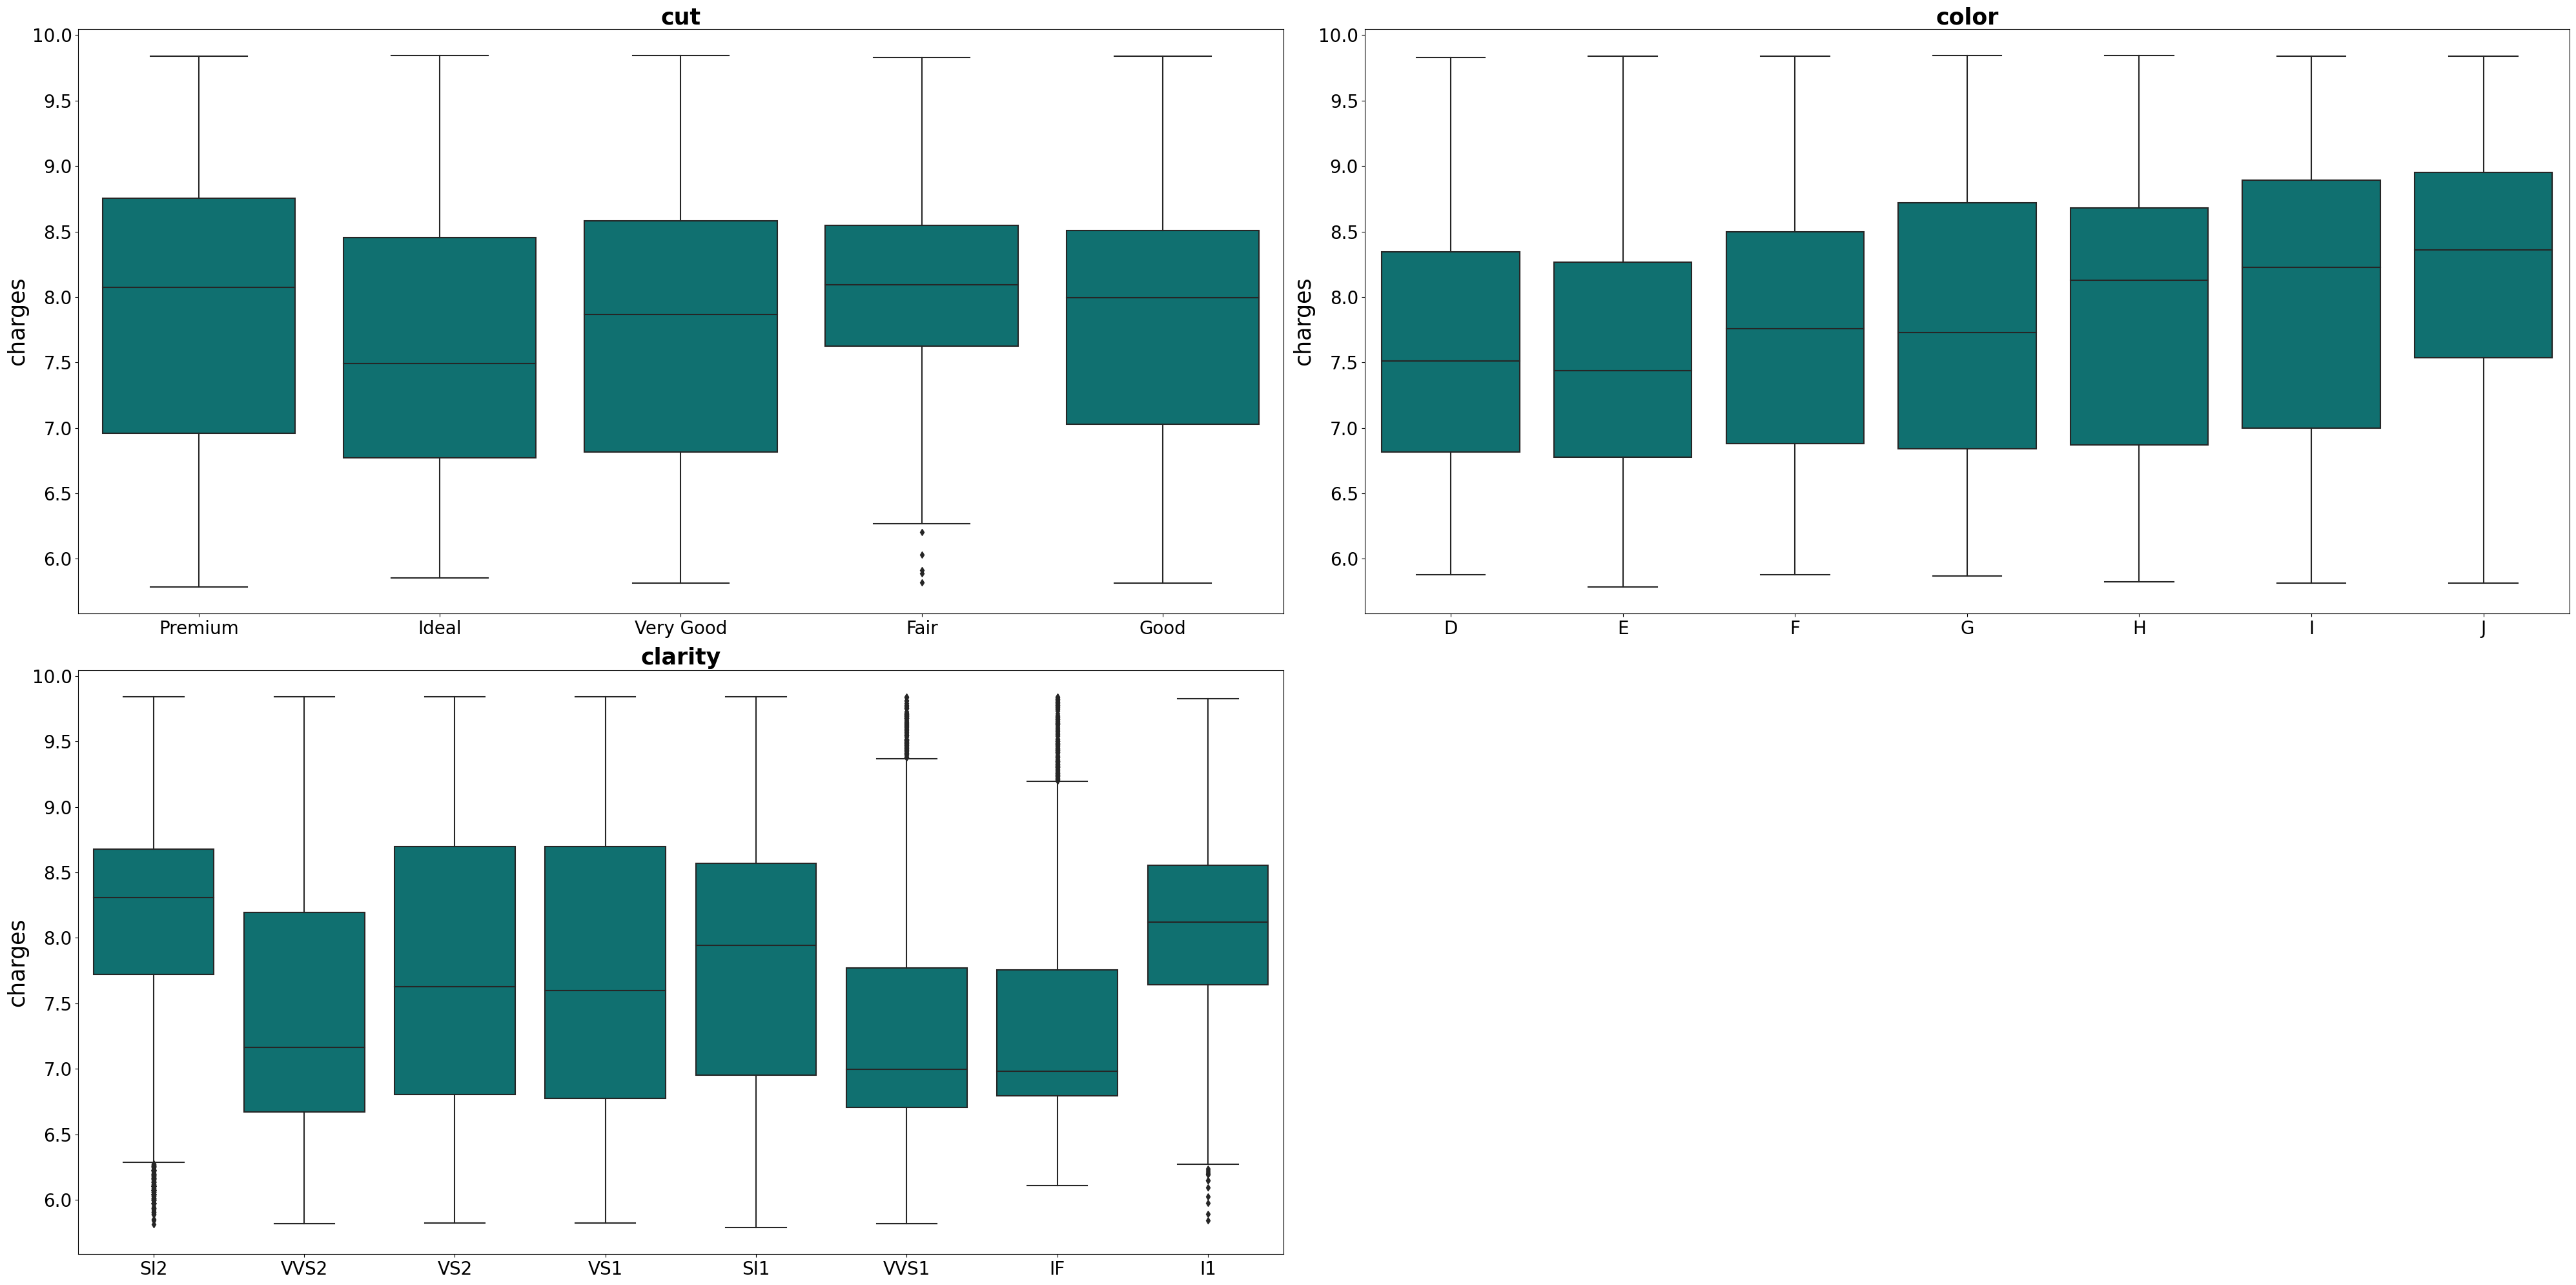

In [50]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (40, 20))


axes = axes.flat

columnas_cat = df2.select_dtypes(include = ["object", "category"]).columns

for i, colum in enumerate(columnas_cat):
    sns.boxplot(
        data = df2,
        x = colum,
        y = "price",
        color = "teal", 
        ax = axes[i])
    
    
    axes[i].set_title(colum, fontsize = 25, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
    axes[i].set_ylabel( "charges", fontsize = 25)

fig.delaxes(axes[-1])

fig.tight_layout();

In [51]:
sp.label_encoder(df2, columnas_cat)

,id,carat,cut,color,clarity,x,y,z,price,price_NORM,price_LOG,price_SQRT,price_NORM2,cut_encoded,color_encoded,clarity_encoded
0,0,-1.127542,Premium,D,SI2,-1.266882,-1.304346,-1.241417,6.353,-0.352854,1.848927,2.520516,0.139581,3,0,3
1,1,0.669758,Ideal,E,VVS2,0.617831,0.656211,0.729545,9.183,0.345050,2.217354,3.030347,0.837485,2,1,7
2,2,-0.064351,Ideal,F,VS2,-0.016361,0.008688,0.004927,7.983,0.049119,2.077314,2.825420,0.541554,2,2,5
3,3,0.846957,Very Good,G,SI2,0.725019,0.692184,0.845484,8.371,0.144803,2.124773,2.893268,0.637238,4,3,3
4,4,-0.975658,Premium,G,VS1,-1.097168,-1.061524,-1.038524,6.588,-0.294901,1.885250,2.566710,0.197534,3,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40450,40450,-0.823773,Premium,D,SI2,-0.847064,-0.818703,-0.806646,6.551,-0.304025,1.879618,2.559492,0.188409,3,0,3
40451,40451,-0.545318,Premium,G,VS2,-0.462976,-0.494942,-0.458829,7.382,-0.099093,1.999045,2.716984,0.393342,3,3,5
40452,40452,0.138162,Good,G,SI2,0.117623,0.152582,0.222312,7.768,-0.003902,2.050013,2.787113,0.488533,1,3,3
40453,40453,0.669758,Very Good,F,VS2,0.599967,0.674197,0.613606,8.726,0.232350,2.166307,2.953980,0.724784,4,2,5


In [52]:
df2.drop(["cut", "color", "clarity", "price_NORM", "price_LOG", "price_SQRT", "price_NORM2"], axis=1, inplace=True)

In [53]:
df2.head()

,id,carat,x,y,z,price,cut_encoded,color_encoded,clarity_encoded
0,0,-1.127542,-1.266882,-1.304346,-1.241417,6.353,3,0,3
1,1,0.669758,0.617831,0.656211,0.729545,9.183,2,1,7
2,2,-0.064351,-0.016361,0.008688,0.004927,7.983,2,2,5
3,3,0.846957,0.725019,0.692184,0.845484,8.371,4,3,3
4,4,-0.975658,-1.097168,-1.061524,-1.038524,6.588,3,3,4


In [54]:
df2.to_csv("../data/train_prep.csv")